# Credit Card Fraud Detection

- 신용 카드 부정 사용자 검출

- 신용카드 사기 검출 분류 실습용 데이터
- 데이터에 class라는 이름의 컬럼이 사기 유무를 의미
- class 컬럼의 불균형이 극심해서 전체 데이터의 0.172%가 1(사기)를 가짐

- 데이터의 불균형이 극심함

In [1]:
import pandas as pd
data_path = './creditcard.csv'
raw_data = pd.read_csv(data_path)
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Class = 0 : 정상, 1: 사기

In [2]:
# Class 개수 Count
raw_data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [3]:
frauds_rate = round(raw_data['Class'].value_counts()[1] / len(raw_data) * 100, 2)
print('Frauds', frauds_rate, '% of the dataset')

Frauds 0.17 % of the dataset


- 데이터 라벨의 불균형이 정말 심하다

#### 그래프로 시각화

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='Class', ylabel='count'>

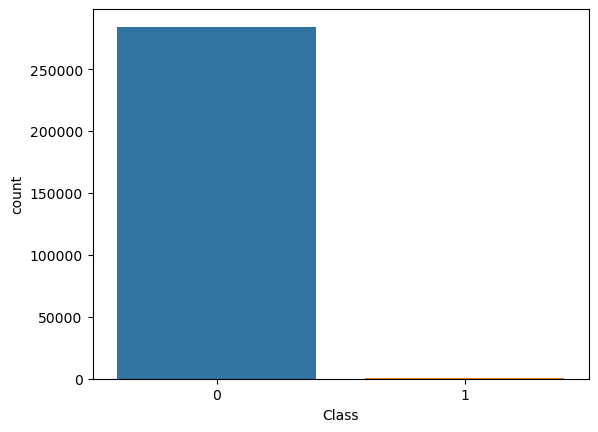

In [5]:
sns.countplot(x= 'Class', data=raw_data)

In [6]:
raw_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
X = raw_data.iloc[:, 1:-1] # V1~V28
y = raw_data.iloc[:, -1]

X.shape, y.shape

((284807, 29), (284807,))

### 데이터 나누기

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify = y) # stratify데이터의 불균형이 심한 경우 중요함

In [9]:
import numpy as np
print(np.unique(y_train, return_counts=True)[1][1] / len(y_train) * 100,'%')

0.17254870488152324 %


## 1st trial

#### 분류기의 성능을 return하는 함수

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    return acc, pre, re, f1, auc

### 성능을 출력하는 함수

In [11]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)

    print('==> Confusion matrix')
    print(confusion)
    print('=====================')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc, pre))
    print('Recall : {0:.4f}, F1 : {1:.4f}, AUC : {2:.4f}'.format(re, f1, auc))

### LogisticRegression

In [77]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print_clf_eval(y_test, lr_pred)

==> Confusion matrix
[[113708     19]
 [    67    128]]
Accuracy : 0.9992, Precision : 0.8707
Recall : 0.6564, F1 : 0.7485, AUC : 0.8281


- 실제 정상 데이터 중 11개를 Fraud라고 예측, 하지만 사기 148개의 데이터 중 60개를 정상 데이터라고 예측
- Accuracy 율은 높지만, Recall은 60%에 미치지 못한다.

### DecisionTree

In [78]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print_clf_eval(y_test, dt_pred)

==> Confusion matrix
[[113706     21]
 [    51    144]]
Accuracy : 0.9994, Precision : 0.8727
Recall : 0.7385, F1 : 0.8000, AUC : 0.8691


- Recall이 높음. 
- 더 향상시킬 수 있을지 고민해봐야 한다.

### RandomForest

In [17]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print_clf_eval(y_test, rf_pred)

CPU times: total: 93.8 ms
Wall time: 768 ms


### LGBMClassifier

- 은행입장에서는 Recall이 좋음ㅡ
- 사용자 입장에서는 Precision이 좋음 (정상사용자이지만 Fraud사용자로 오해받아 귀찮아질 수 있으므로)

# 모델과 데이터를 주면 성능을 출력하는 함수

In [15]:
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return get_clf_eval(y_test, pred)

# 다수의 모델의 성능을 정리해서 DataFrame으로 반환하는 함수 작성

In [16]:
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy','preicision', 'recall', 'f1', 'roc_auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [ ]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

```
==> Confusion matrix
[[85289     6]
 [   34   114]]
=====================
Accuracy : 0.9995, Precision : 0.9500
Recall : 0.7703, F1 : 0.8507, AUC : 0.8851
CPU times: total: 1min 9s
Wall time: 31.8 s
```

In [22]:
result

,Accuracy,preicision,recall,f1,roc_auc
LinearRegression,0.999169,0.888889,0.594595,0.712551,0.797233
DecisionTree,0.999345,0.883333,0.716216,0.791045,0.858026
RandomForest,0.999497,0.956522,0.743243,0.836502,0.871592
LightGBM,0.999532,0.950000,0.770270,0.850746,0.885100


- RandomForest와 LGBM이 현재 상태로는 가장 좋은 성능을 보여준다.
- 현 상황에서는 Accuracy보다 recall의 수치가 중요한 것으로 보인다.

- LinearReg -> LogisticReg

# 2nd Trial
# Raw_data의 Amount컬럼 확인
- 카드 사용 Amount 확인
- 컬럼의 분포가 특정 대역이 아주 많다.

- 너무 몰려있는 건 문제가 될 수 있음

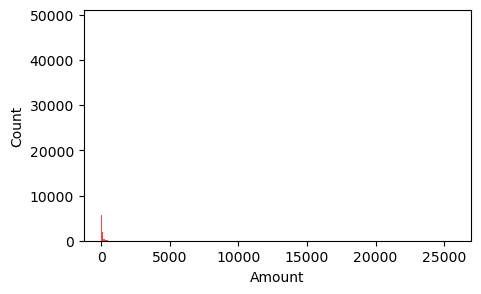

In [27]:
plt.figure(figsize=(5, 3))
sns.histplot(x=raw_data['Amount'], color='r');

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
amount_n = scaler.fit_transform(raw_data['Amount'].values.reshape(-1, 1))

raw_data_copy = raw_data.iloc[:, 1: -2]
raw_data_copy['Amount_Scaled'] = amount_n
raw_data_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [33]:
raw_data['Amount'].values # type : np.array

array([149.62,   2.69, 378.66, ...,  67.88,  10.  , 217.  ])

In [32]:
raw_data['Amount'].values.reshape(-1, 1) # shape이 1이 되게

array([[149.62],
       [  2.69],
       [378.66],
       ...,
       [ 67.88],
       [ 10.  ],
       [217.  ]])

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(raw_data_copy, y, test_size=0.4, random_state=13, stratify=y)

In [ ]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

result

- recall에 큰 변화는 없다.

# 모델별 ROC커브

### ROC커브 시각화 함수

In [45]:
from sklearn.metrics import roc_curve

def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 10))

    for model in models:
        pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model)

    plt.plot([0, 1], [0, 1], 'k--', label='random guess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

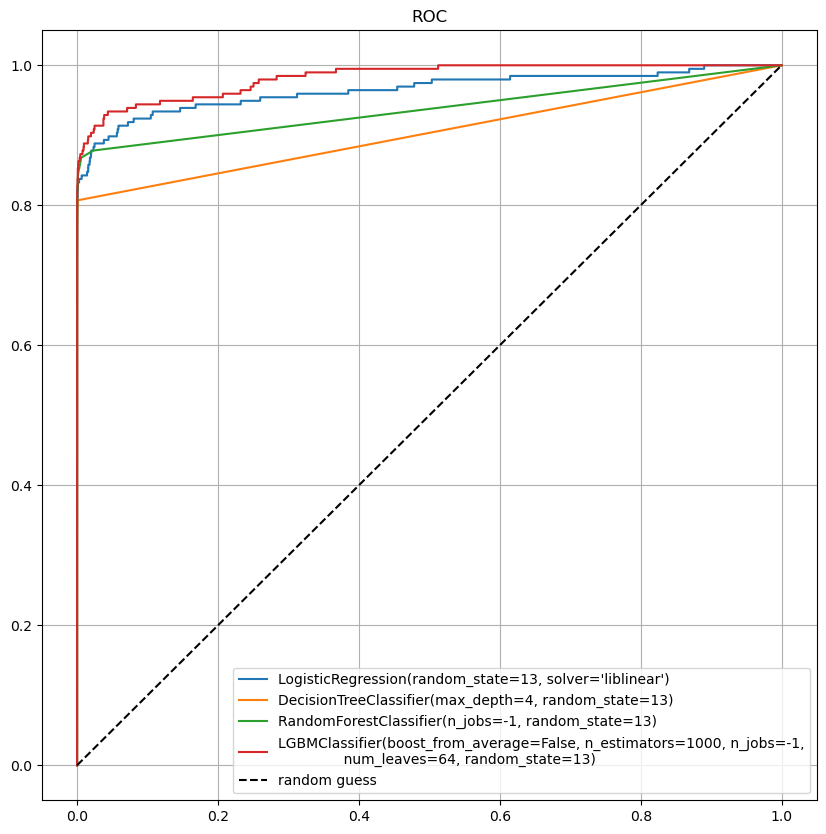

In [46]:
draw_roc_curve(models, model_names, X_test, y_test)

- LightGBM이 매우 좋아보임.

# log scale

- 로그 함수를 적용시키기
- x값이 커질수록 y를 억제하는 기능이 있음

### Amount컬럼을 로그함수에 적용하기

In [47]:
amount_log = np.log1p(raw_data['Amount'])
raw_data_copy['Amount_Scaled'] = amount_log

In [49]:
X_train, X_test, y_train, y_test = train_test_split(raw_data_copy, y, test_size=0.4, random_state=13, stratify=y)

In [ ]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)


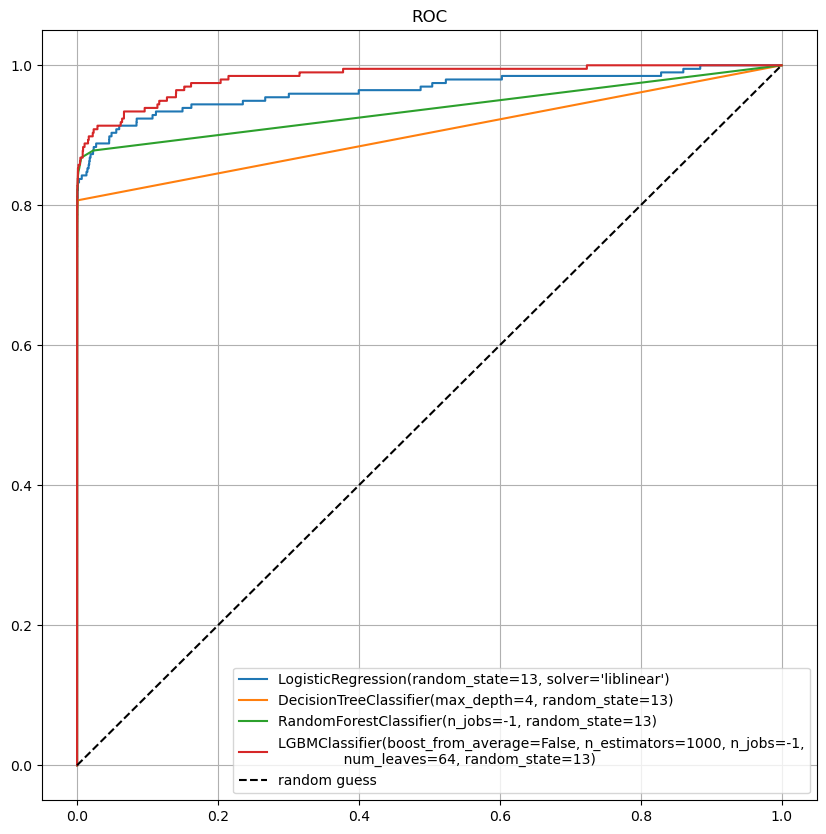

In [51]:
draw_roc_curve(models, model_names, X_test, y_test)

# 3rd Trial

# Outlier 제거

### Outlier의 인덱스를 파악하기

In [52]:
def get_outlier(df=None, column=None, weight = 1.5):
    fraud = df[df['Class']==1][column] # fraud데이터에 대해서만 outlier확인

    quantile_25 = np.percentile(fraud.values, 25) # q1
    quantile_75 = np.percentile(fraud.values, 75) # q3

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight

    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

In [54]:
get_outlier(df=raw_data, column='V14') # V14에서 outlier

Index([8296, 8615, 9035, 9252], dtype='int64')

### Outlier인덱스 제거

In [57]:
outlier_index = get_outlier(df=raw_data, column='V14')
raw_data_copy.drop(outlier_index, axis=0, inplace=True)
raw_data_copy.shape

(284803, 29)

### train_test_split

In [60]:
X = raw_data_copy

raw_data.drop(outlier_index, axis=0, inplace=True)
y = raw_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=13, stratify=y)

In [ ]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

result

```
Accuracy	preicision	recall	f1	roc_auc
LogisticRegression	0.999245	0.870748	0.656410	0.748538	0.828122
DecisionTree	0.999368	0.872727	0.738462	0.800000	0.869138
RandomForest	0.999500	0.920732	0.774359	0.841226	0.887122
LightGBM	0.999579	0.962264	0.784615	0.864407	0.892281
```

# 4th Trial

# Undersampling vs Oversampling
- 데이터의 불균형이 극심할 때 불균형한 두 클래스의 분포를 강제로 맞춰보는 작업
- 언더샘플링 : 많은 수의 데이터를 적은 수의 데이터로 강제로 조정
- 오버샘플링 : 원본데이터의 피쳐값들을 아주 약간 변경하여 증식
- 대표적으로 SMOTE 방법이 있음
- 적은 데이터 세트에 있는 개별 데이터를 k-최근접이웃 방법으로 찾아서 데이터의 분포 사이에 새로운 데이터를 만드는 방식
- imbalanced-learn이라는 Python pkg가 있음

### oversampling 하기

In [65]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train) # test데이터는 건들면 안됨. Scaler제외하고 train에 하는 작업을 test에 작업하면 안된다. train데이터에 대해서만 불려야함.

### 행, 열 갯수 확인

In [66]:
X_train.shape, y_train.shape

((170881, 29), (170881,))

In [67]:
X_train_over.shape, y_train_over.shape

((341176, 29), (341176,))

In [69]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_over, return_counts=True))

(array([0, 1], dtype=int64), array([170588,    293], dtype=int64))
(array([0, 1], dtype=int64), array([170588, 170588], dtype=int64))


### 성능 확인

In [ ]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']
result = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)



In [75]:
result

,Accuracy,preicision,recall,f1,roc_auc
LogisticRegression,0.975773,0.060637,0.907692,0.113680,0.941791
DecisionTree,0.956734,0.034238,0.892308,0.065947,0.924576
RandomForest,0.999403,0.843243,0.800000,0.821053,0.899873
LightGBM,0.999500,0.867021,0.835897,0.851175,0.917839


- RandomForest, LightGBM이 다섯개의 점수에서 골고루 좋은 점수를 얻었다.

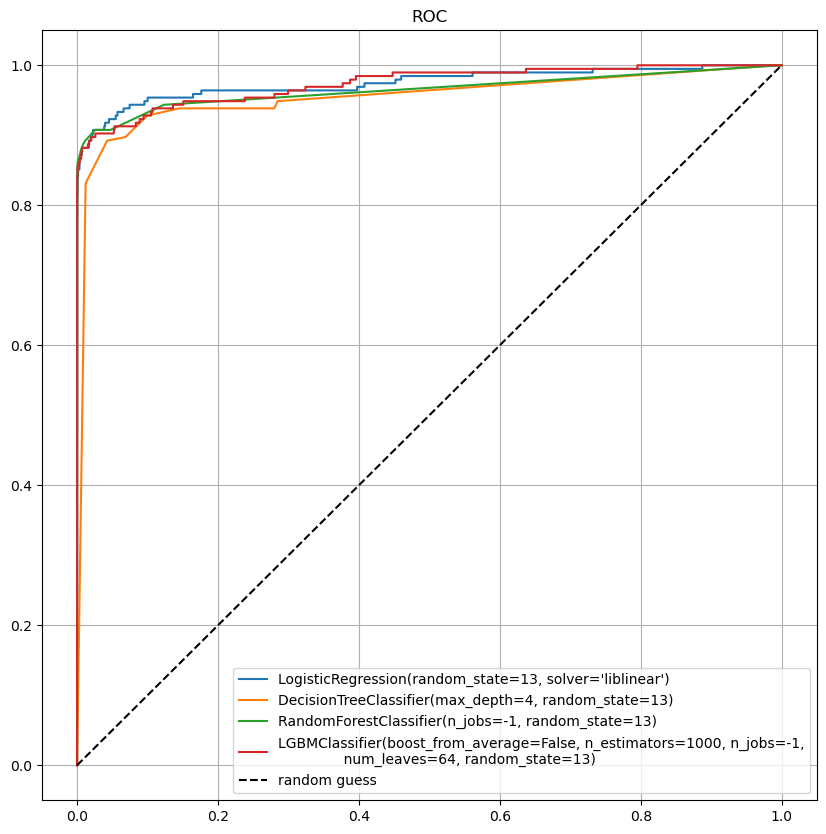

In [71]:
draw_roc_curve(models, model_names, X_test, y_test)